# Init Project

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import os
os.chdir('gdrive/My Drive/GoogleColab/ProjectMLFinal') # Đường dẫn đến các file liên quan

In [3]:
import cv2
from google.colab.patches import cv2_imshow
from OpenCV.DetectionOpenCV import DetectionOpenCV
from OpenCV.SegmentationOpenCV import SegmentationOpenCV
from OpenCV.UtilitiesOpenCV import UtilitiesOpenCV
from YOLO.DetectionYOLO import DetectionYOLO
from WPODNET.DetectionWPODNET import DetectionWPODNET
from Skimage.SegmentationSkimage import SegmentationSkimage
from PreRecognition import PreRecognition

from itertools import chain
from scipy import misc
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
import matplotlib.pyplot as plt
import glob
import pathlib

# Function

## General

In [4]:
def fix_char(_Char, _IsNumber):
  result = _Char
  char_key = ['I','J','O','Q','R','W']
  if _Char in char_key:
    if char == 'I' or  char == 'J':
      result = '1'
    elif char == 'O':
      result = '0'
    elif char == 'Q':
      if _IsNumber:
         result = '0'
      else:
         result = 'O'
    elif char == 'R':
      if _IsNumber:
         result = '0'
      else:
         result = 'O'
    else:
      result = 'V'  

  if _IsNumber:
    if _Char == 'B':
      result = '8'
    elif _Char == 'D':
      result = '0'
    elif _Char == 'G':
      result = '6'
    elif _Char == 'A':
      result = '4'      
  else:
    if _Char == '1':
      result = 'A'

  return result

def filter_char(char_plate):
  plate_result = ''
  i = 0
  for char in char_plate: 
    result = ''
    if i == 2:
      result = fix_char(char, False)
    else:
      result = fix_char(char, True)
    i += 1
    plate_result += result    
  return plate_result

## Detect + Segment

In [5]:
def segmentOpenCVLong(_ImgPlate):
  lstSegment_Long_OpnenCV = []
  img_draw = np.array([])
  img_binary = np.array([])
  result_detection = _ImgPlate.copy()
  #-----------------------------------------------------------------------------------------------------------------------------------------
  #Tách ký tự ra khỏi biển số
  preRecognition = PreRecognition() 
  utilitiesOpenCV = UtilitiesOpenCV() 
  plate_segment = cv2.cvtColor(result_detection, cv2.COLOR_RGB2BGR)
  segmentationOpenCV = SegmentationOpenCV(_TypePlate = 0, _SizeWidth = 0, _SizeHeight = 0, _Border = 0, 
                                          _Threshold = 0, _CropPadding = 2, _RatioMin = 1.0, _RatioMax = 7.5, _GaussFilter = 3, _BilaFilter = 0)    
  img_resize = plate_segment
  status, result_segment, img_draw, img_binary = preRecognition.segmentation(_ImgInput = img_resize, _TypeSegmentation = 1, _Object = segmentationOpenCV)
  if status == 0 or len(result_segment) == 0 or img_draw.size == 0:
    return lstSegment_Long_OpnenCV, img_draw, img_binary

  #-----------------------------------------------------------------------------------------------------------------------------------------
  #Điều chỉnh kích thước các ký tự        
  for seg in result_segment:        
    char = utilitiesOpenCV.resize_border_threshold(_ImgInput = seg, _SizeWidth = 26, _SizeHeight = 26, _Border = 1, _BorderType = cv2.BORDER_CONSTANT, _ThresholdMin = 127)
    lstSegment_Long_OpnenCV.append(char)  
  
  return lstSegment_Long_OpnenCV, img_draw, img_binary

def segmentOpenCVShort(_ImgPlate):
  lstSegment_Long_OpnenCV = []
  img_draw = np.array([])
  img_binary = np.array([])
  img_detection = _ImgPlate.copy()
  #-----------------------------------------------------------------------------------------------------------------------------------------
  #Tách ký tự ra khỏi biển số
  preRecognition = PreRecognition() 
  utilitiesOpenCV = UtilitiesOpenCV() 
  segmentationOpenCV = SegmentationOpenCV(_TypePlate = 1, _SizeWidth = 470, _SizeHeight = 0, _Border = 5, 
                                          _Threshold = 0, _CropPadding = 2, _RatioMin = 1.5, _RatioMax = 5.0, _GaussFilter = 3, _BilaFilter = 0)    
  plate_enhance = utilitiesOpenCV.change_brightness(_ImgInput = img_detection, _Alpha = 1.0, _Beta = -10) 
  plate_segment = cv2.cvtColor(plate_enhance, cv2.COLOR_RGB2BGR)
  img_resize = plate_segment
  status, result_segment, img_draw, img_binary = preRecognition.segmentation(_ImgInput = img_resize, _TypeSegmentation = 1, _Object = segmentationOpenCV)
  if status == 0 or len(result_segment) == 0 or img_draw.size == 0:
    return lstSegment_Long_OpnenCV, img_draw, img_binary

  #-----------------------------------------------------------------------------------------------------------------------------------------
  #Điều chỉnh kích thước các ký tự        
  for seg in result_segment:  
    if(seg.shape[1] < 40 or seg.shape[0] < 105): continue
    if(seg.shape[1] > 80 or seg.shape[0] > 160): continue   
    char = utilitiesOpenCV.resize_border_threshold(_ImgInput = seg, _SizeWidth = 26, _SizeHeight = 26, _Border = 1, _BorderType = cv2.BORDER_CONSTANT, _ThresholdMin = 127)
    lstSegment_Long_OpnenCV.append(char)  
  
  return lstSegment_Long_OpnenCV, img_draw, img_binary

def detectWPODNET_segmentOpenCV(_ImgVehicle, _ImgName = ''):
  lst_char = []
  img_contour = np.array([])
  img_binary = np.array([])
  img_detection = np.array([])
  #-----------------------------------------------------------------------------------------------------------------------------------------
  # Phát hiện biển số trong ảnh
  preRecognition = PreRecognition()    
  wpod_net_path = "WPODNET/wpod-net_update1.json"
  detectionWPODNET = DetectionWPODNET(_ModelWPODNET = wpod_net_path, _SizeMax = 608, _SizeMin = 288, _Threshold = 0.5)
  status, img_detection = preRecognition.detection(_ImgInput = _ImgVehicle, _TypeDetection = 2, _Object = detectionWPODNET)
  if status == 0 or img_detection.size == 0:
    return lst_char, img_contour, img_binary

  #-----------------------------------------------------------------------------------------------------------------------------------------
  # Lưu thông tin biển số xe dectect được 
  # if _ImgName != '':
  #   output_path = 'DataPlate/WPODNET/Short/' + _ImgName # 'DataPlate/WPODNET/Long/' + _ImgName
  #   cv2.imwrite(output_path, img_detection) 

  #-----------------------------------------------------------------------------------------------------------------------------------------
  # Tách ký tự ra khỏi biển số
  if img_detection.shape[0] > 190: # Biển ngắn
    lst_char, img_contour, img_binary = segmentOpenCVShort(_ImgPlate = img_detection)
    return lst_char, img_contour, img_binary, img_detection
  else: # Biển dài
    lst_char, img_contour, img_binary = segmentOpenCVLong(_ImgPlate = img_detection)
    return lst_char, img_contour, img_binary, img_detection

  return lst_char, img_contour, img_binary, img_detection

## CNN

In [6]:
model = load_model('model/chars_5k.h5')
def predict_cnn(result_image):
  bienso = ''
  # 10. Dự đoán ảnh
  aphabet = ['0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

  for i in range(0, len(result_image)):
    y_predict = model.predict(result_image[i].reshape(1,28,28,1))
    #print('Giá trị dự đoán: ', np.argmax(y_predict))
    #print('Ký tự tương ứng: ', aphabet[np.argmax(y_predict)])
    bienso+= aphabet[np.argmax(y_predict)]
    
  return bienso

## SVM

In [7]:
model_svm = cv2.ml.SVM_load('model/svm_chars_1205_r_99.xml')
def predict_svm(result_image):
  digit_w = 28 # Kich thuoc ki tu
  digit_h = 28 # Kich thuoc ki tu
  aphabet = ['0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']


  plate_info = ""  
  for i in range(0, len(result_image)):
    curr_num= result_image[i]
    curr_num = np.array(curr_num,dtype=np.float32)
    curr_num = curr_num.reshape(-1, digit_w * digit_h)
                
    # Dua vao model SVM
    result = model_svm.predict(curr_num)[1]
    result = int(result[0, 0])
    result = aphabet[result]

    plate_info +=result
  return plate_info

# Test One

/content/gdrive/My Drive/GoogleColab/DataDemo/DataVehicle/Long150/20A18668.jpg
Ảnh đầu vào: 


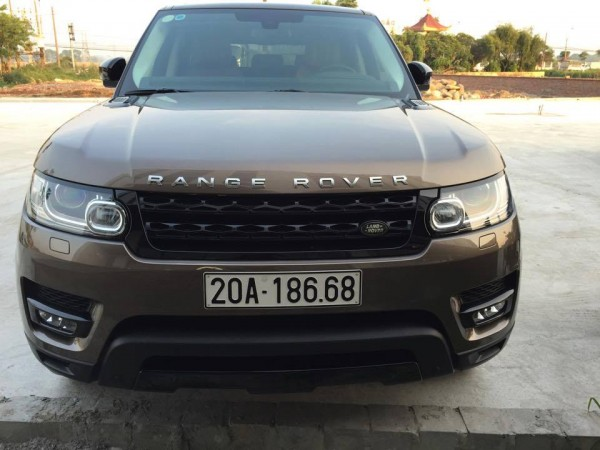

----------------------------------------------------------------------------------------------------------------------
(24, 32, 8)
Biển số phát hiện được: 


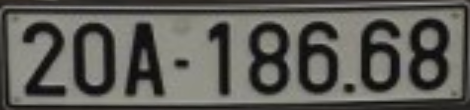

----------------------------------------------------------------------------------------------------------------------
Các ký tự tách được: 


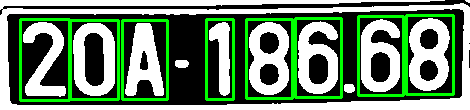

Số lượng ký tự tách được:  8
----------------------------------------------------------------------------------------------------------------------
Kết quả nhận diện bằng CNN:  20A18668
Kết quả nhận diện bằng SVM:  20A38668


In [8]:
dir_path = '/content/gdrive/My Drive/GoogleColab/DataDemo/DataVehicle/Long150'
img_name = '20A18668.jpg'
path_vehicle = dir_path + '/' + img_name
print(str(path_vehicle))
img_vehicle = cv2.imread(str(path_vehicle))
print("Ảnh đầu vào: ")
cv2_imshow(img_vehicle)
print("----------------------------------------------------------------------------------------------------------------------")

file_name = os.path.basename(path_vehicle)
lst_char, img_contour, img_binary, img_detection = detectWPODNET_segmentOpenCV(_ImgVehicle = img_vehicle, _ImgName = file_name)
print("Biển số phát hiện được: ")
if img_detection.size != 0:
    cv2_imshow(img_detection)
print("----------------------------------------------------------------------------------------------------------------------")

print("Các ký tự tách được: ")
if img_contour.size != 0:
    cv2_imshow(img_contour)
    for item in lst_char:
      cv2_imshow(item)
    
    print("Số lượng ký tự tách được: ", len(lst_char))
print("----------------------------------------------------------------------------------------------------------------------")
if len(lst_char) != 0:
    cnn = predict_cnn(lst_char)
    svm = predict_svm(lst_char)
    print("Kết quả nhận diện bằng CNN: ", cnn)
    print("Kết quả nhận diện bằng SVM: ", svm)

# Test Detect - Seg - Reco

In [10]:
# lst_path_vehicle_long = pathlib.Path('/content/gdrive/My Drive/GoogleColab/DataDemo/').glob('DataVehicle/Long' + "/*.*")
# lst_path_vehicle_short = pathlib.Path('/content/gdrive/My Drive/GoogleColab/DataDemo/').glob('DataVehicle/Short' + "/*.*")
# lst_path_vehicle = chain(lst_path_vehicle_long, lst_path_vehicle_short)
lst_path_vehicle = pathlib.Path('/content/gdrive/My Drive/GoogleColab/DataDemo/').glob('DataVehicle/All' + "/*.*")
total_img = 0
total_error_detect_segment = 0
total_error_recognition_cnn = 0
total_error_recognition_svm = 0

lst_path_vehicle_sort = sorted(lst_path_vehicle)
for path_vehicle in lst_path_vehicle_sort:
  try:
    if total_img >= 20: break      
    total_img += 1
    # if total_img < 111:
    #   continue
    print('STT: ' + str(total_img) + ' |  '+ str(path_vehicle))
    
    file_name = os.path.basename(path_vehicle)
    real_char =  str(os.path.splitext(file_name)[0])
    #-----------------------------------------------------------------------------------------------------------------------------------------
    # Đọc file ảnh đầu vào
    img_vehicle = cv2.imread(str(path_vehicle))
    cv2_imshow(img_vehicle)

    #-----------------------------------------------------------------------------------------------------------------------------------------
    # Phát hiện biển số - Tách ký tự ra khỏi biển số
    lst_char, img_contour, img_binary, img_detection = detectWPODNET_segmentOpenCV(_ImgVehicle = img_vehicle, _ImgName = file_name)

    if img_binary.size != 0:
      cv2_imshow(img_binary)
    
    if img_contour.size != 0:
      cv2_imshow(img_contour)
    else:
      print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ No char segment:', str(real_char))
      total_error_detect_segment += 1

    #-----------------------------------------------------------------------------------------------------------------------------------------
    # Dự đoán biển số
      # CNN      
    cnn = predict_cnn(lst_char)    
    print(cnn)     
      # SVM
    svm = predict_svm(lst_char)
    print(svm) 

    if str(cnn) != str(real_char):
      print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ CNN:', str(real_char) + ' != ' + str(cnn))      
      total_error_recognition_cnn += 1 

    if str(svm) != str(real_char):
      print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ SVM:', str(real_char) + ' != ' + str(svm))
      total_error_recognition_svm += 1       

    if (len(lst_char) != 9 and len(lst_char) != 8) and (str(cnn) != str(real_char) or str(svm) != str(real_char)):
        total_error_detect_segment += 1

  except:
    total_error_detect_segment += 1
    total_error_recognition_cnn += 1
    total_error_recognition_svm += 1  
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~Exception:', str(path_vehicle))
  #print('\n-------------------------------------------------------------------\n')
print('Total Image:', total_img)
print('Total Error Segment:', total_error_detect_segment)
print('Error Rate Segment:', (total_error_detect_segment/total_img) * 100)
print('Total Error Recognition CNN:', total_error_recognition_cnn)
print('Error Rate Recognition CNN:', (total_error_recognition_cnn/total_img) * 100)
print('Total Error Recognition SVM:', total_error_recognition_svm)
print('Error Rate Recognition SVM:', (total_error_recognition_svm/total_img) * 100)

Output hidden; open in https://colab.research.google.com to view.